In [1]:
import rebound  # will only work if rebound is installed in your python distro
import numpy as np  #  math stuff 
import matplotlib.pyplot as plt  # generic plotting stuff 
%matplotlib inline 


### Based on Numerical problem for Problem set #5

In this problem, we will create a star cluster that described by  a Plummer model,  
https://en.wikipedia.org/wiki/Plummer_model .

The Plummer model is modified so that particles are kept within a particular radius. 

In [58]:
from scipy import interpolate   # needed so we can use interp1d in the Plummer initial conditions generating routine

def Plummer(N, r0, totmass, G,rlim,seed=None):
    """Generate the initial conditions for an isotropic Plummer model (BT eqs. 4.83 with n=5, 4.92, 2.44b).
    modified from the routine by J Bailin on this repository https://github.com/jbailinua/gravhopper
    Apparently rebound's python version lacks the plummer model initial condition generation code that is available in the c-version
    I am adding a cutoff for a maximum radius which should help with display in rebound    
    Parameters
    ----------
    N  :     (int) Number of particles
    r0 :     (float) Cluster scale radius (This appears to be the Plummer radius not the virial radius)
    totmass: (float) Total cluster mass
    G:       (float) gravitational constant 
    rlim:    (float) discard particles that have radius from the center larger than rlim 
    seed : None, or (int), 
            Seed to initialize random number generator so as to enable repeatable initial conditions
            
    Returns
    -------
    xarr,yarr,zarr,vxarr,vyarr,vzarr,mass each as 1d N length float arrays  
    """

    xarr = np.zeros(N)
    yarr = np.zeros(N)
    zarr = np.zeros(N)
    vxarr = np.zeros(N)
    vyarr = np.zeros(N)
    vzarr = np.zeros(N)

    if (seed is None):
        from datetime import datetime
        seed = int(datetime.now().timestamp())  # if you want a randomly chosen set 

    rng = np.random.default_rng(seed) # random number generator in python
    nparticles = 0
    # loop adding particles, check whether we accept the particle until we reach N particles 
    while (nparticles < N):
        # generate random coordinates and velocities. Uses the law of
        # transformation of probabilities.
        rad_xi = rng.uniform(0.0, 1.0) # uniform distribution 
        radius = r0 / np.sqrt(rad_xi**(-2./3) - 1)   # r0 used here!
        costheta = rng.uniform(-1.0, 1.0)
        phi = rng.uniform(0.0, 2.0*np.pi)
        sintheta = np.sqrt(1.0 - costheta**2)
        x = radius * sintheta * np.cos(phi) # particle positions!
        y = radius * sintheta * np.sin(phi)
        z = radius * costheta
        r = np.sqrt(x*x + y*y + z*z)
        if (r < rlim):  # accept particle if r is within this 
            xarr[nparticles] = x
            yarr[nparticles] = y
            zarr[nparticles] = z
            # we need to chose the velocity component numerically
            # from Aarseth+ 1974, we want to draw q from q^2 (1-q^2)^(7/2)
            # and then assign the magnitude of v to be
            # v = q sqrt(2) (1 + r^2/b^2)^(-1/4)
            qax = np.arange(0, 1.01, 0.01)
            q_prob = qax**2 * (1. - qax**2)**(3.5)
            q_cumprob = np.cumsum(q_prob) # cumulative probability
            q_cumprob /= q_cumprob[-1]    # normalized correctly to end up at 1
            probtransform = interpolate.interp1d(q_cumprob, qax)   # reverse interpolation  # needs scipy.interpolate.interp1d 
            # now get the uniform random deviate and transform it
            vel_xi = rng.uniform(0.0, 1.0) # , size=N)
            q = probtransform(vel_xi)
            velocity = q * np.sqrt(2. * G * totmass / r0) * (1. + (radius/r0)**2)**(-0.25)
            cosveltheta = rng.uniform(-1.0, 1.0)
            velphi = rng.uniform(0.0, 2.0*np.pi)
            sinveltheta = np.sqrt(1.0 - cosveltheta**2)
            vx = velocity * sinveltheta * np.cos(velphi) # particle velocities!
            vy = velocity * sinveltheta * np.sin(velphi)
            vz = velocity * cosveltheta
            vxarr[nparticles] = vx
            vyarr[nparticles] = vy
            vzarr[nparticles] = vz
            nparticles +=1

    mass = np.ones((N)) * (totmass/N) # generate particle masses
    
    v2 = vxarr**2 + vyarr**2 + vzarr**2
    # compute total kinetic energy 
    total_K = np.sum(mass*v2/2)
    V_virial = 2*total_K
    r_V = V_virial/(G*totmass)
    print('total KE {:.2e} r_V={:.2e}'.format(total_K,r_V))
    # return arrays, note no particle radius yet 
    return xarr,yarr,zarr,vxarr,vyarr,vzarr,mass 


testit = 1
if (testit==1):  # for testing the above routine to see if it works!
    M_cluster = 1; R_cluster = 1; N=300; G=1.0
    r0 = 16./(3.*np.pi)*R_cluster;   # Characteristic length scale
    # this means that R_cluster is the Plummer radius, and r0 is the virial radius? 
    print('vt = {:.1e}'.format(r0))
    print('16/3pi = {:.2f}'.format(16./(3.*np.pi)))
    print('3pi/64 = {:.2f}'.format(3*np.pi/64.0))
    rlim = 10*r0
    x,y,z,vx,vy,vz,mass  = Plummer(N, 1, M_cluster, G,rlim, seed=None)
    # If I give radius of 1, then I get KE energy of 3pi/64 which should be the same as total energy in units of Plummer radius
    # so I think that input radius here is Plummer radius not the virial radius
    

# return a list of x,y positions and radii from cluster center as a function of time 
# here sim is a rebound simulation class structure
def getxyr(sim):
    xarr = np.zeros(sim.N)
    yarr = np.zeros(sim.N)
    rarr = np.zeros(sim.N)
    for i in range(sim.N):
        xarr[i] = sim.particles[i].x
        yarr[i] = sim.particles[i].y
        r2 = sim.particles[i].x*sim.particles[i].x + sim.particles[i].y*sim.particles[i].y \
            + sim.particles[i].z*sim.particles[i].z
        rarr[i] = np.sqrt(r2)
    return xarr,yarr,rarr


vt = 1.7e+00
16/3pi = 1.70
3pi/64 = 0.15
total KE 1.41e-01 r_V=2.82e-01


In [66]:
# set up a simulation with 
# arguments:
#   N: number of cluster particles, 
#   M_cluster: total mass of cluster 
#   R_cluster: radius of cluster , seems to be the Plummer radius 
#   particle_density:  sets radius of particles in units of rho_0 of the cluster 
#    --- G = 1 is set, bounding box is set , initial particles are not allowed outside the box
#   ---- tree integrator used 
# returns:
#   sim:  the rebound simulation
#   r0:   characteristic length scale , virial radius?
#   t0:   relaxation time 
#   v0:   a characteristic velocity scale 

def create_sim(N,M_cluster,R_cluster,particle_density):
    sim = rebound.Simulation() # create rebound simulation !
    sim.G = 1.0

    #M_cluster = 1             # total mass of the cluster
    #R_cluster = 1;            # Plummer Radius of the cluster
    #N = 200 # number of particles 
    E_cluster = 3./64.*np.pi*sim.G*M_cluster*M_cluster/R_cluster;   # total Energy of the cluster
    r_v = 16./(3.*np.pi)*R_cluster;   # Characteristic length scale, is the virial radius 
    t0 = sim.G*np.power(M_cluster,5./2.)*np.power(4.*E_cluster,-3./2.)*N/np.log(0.4*N); # Relaxation time
    print("Virial radius:  \n", r_v);
    print("Characteristic time (relaxation): \n", t0);
    print("particle mass:  \n", M_cluster/N);
    v0=np.sqrt(sim.G*M_cluster/R_cluster)
    print("Characteristic velocity: \n",v0)  # central velocity dispersion should be 1/6 GM/R 
    rho_cluster = 3.0/(4.0*np.pi)*M_cluster/R_cluster**3   # central mass density of cluster 
    print('rho_0 {:.1e}'.format(rho_cluster))

    #sim.boundary   = "open" 
    sim.integrator    = 'LEAPFROG';   # to find list of possible integrators ?sim.integrator
    sim.dt            = 2e-5*t0;     # timestep
    sim.softening     = 0.01*R_cluster;    # Softening parameter
    sim.gravity    = "tree"

    boxsize = 30.0*R_cluster  # viewing, also relevant for tree 
    sim.configure_box(boxsize)
    # sim.boundary = "none"  # by default no boundary 

    rlim = boxsize/2   # let's try this!

    
    # Create a bunch of particles consistent with a Plummer model with N particles 
    x,y,z,vx,vy,vz,mass  = Plummer(N, R_cluster, M_cluster, sim.G,rlim, seed=None)
    # add these particles to the simulation 
    pradius = np.power(3.0*mass/(4.0*np.pi*particle_density), 1.0/3.0)  # compute particle radius 
    for i in range(N):
        sim.add(m=mass[i],x=x[i],y=y[i],z=z[i],vx=vx[i],vy=vy[i],vz=vz[i],r = pradius[i],hash=i)

    sim.move_to_com()  # move to center of mass 
    return sim,r0,t0,v0

In [61]:
# display the simulation xy positions and radial distribution
# if mm = 1 then show the extra massive particle in read,  otherwise don't
def show_sim(sim,mm):
    xarr,yarr,rarr = getxyr(sim)
    fig,axarr = plt.subplots(1,2,figsize=(5,2))
    axarr[0].plot(xarr,yarr,'.',ms=1)
    if (mm==1):
        axarr[0].plot(xarr[-1],yarr[-1],'ro')  # plot massive particle!
    axarr[0].set_aspect('equal')
    boxsize = sim.boxsize.x 
    axarr[0].set_ylim(-boxsize,boxsize)
    axarr[0].set_xlim(-boxsize,boxsize)
    jj = axarr[1].hist(rarr,bins=30,range=[0,20])
    axarr[1].set_xlabel('r')
    plt.show()

In [67]:
M_cluster = 1; R_cluster = 1; N=300
particle_density = 1e-3
sim_a,r0,t0,v0 = create_sim(N,M_cluster,R_cluster,particle_density)  # create a simulation with a cluster in it


Virial radius:  
 1.6976527263135504
Characteristic time (relaxation): 
 138.6074263486668
particle mass:  
 0.0033333333333333335
Characteristic velocity: 
 1.0
rho_0 2.4e-01
total KE 1.42e-01 r_V=2.83e-01


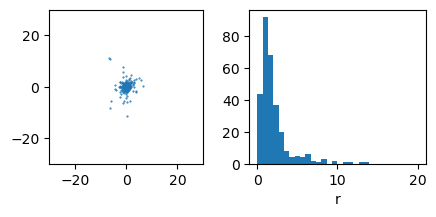

In [68]:
sim_a.integrate(1)
show_sim(sim_a,0) # integrate to t=1, show the simulation and the radial distribution 
xarr_a_0,yarr_a_0,rarr_a_0 = getxyr(sim_a) # 
# store some arrays

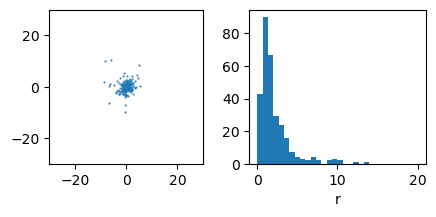

In [69]:
sim_a.integrate(20)
show_sim(sim_a,0)
xarr_a_20,yarr_a_20,rarr_a_20 = getxyr(sim_a)

In [ ]:
# Compute the coefficient of restitution for a pair of particles bouncing off each other
# as a function of the velocity difference v between the two objects 
# and r the distance between them (at impact)
# units: v  [m/s] and r [m] 
# returns the coefficient of restitution eps 
#   which is probably defined as the ratio of post and pre relative velocity magnitudes  
def cor_bridges(r, v):
    v32 = 0.01 # m/s velocity giving eps = 0.32, to increase damping lower this number 
    eps = 0.32*pow(abs(v)/v32 + 1e-6,-0.234) # high velocity encounters have lower coefficents of restitution
    if eps>1.:  # keep at or below 1
        eps=1.
    if eps<0.01:  
        eps=0.01  # always bounce a little bit
    return eps
    # eps is 0.32 at v = 0.01 m/s, eps is lower than this at higher velocities 
# You could modify this routine, or create an extra similar routine if you want to adjust the dissipation rate 


Take a look at this:
https://github.com/hannorein/rebound/blob/main/ipython_examples/User_Defined_Collision_Resolve.ipynb